In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class PerceptronMulticapa:
    """
    Clase para implementar un Perceptrón Multicapa (MLP) desde cero,
    con optimización Adam para el descenso del gradiente.

    Parámetros:
    - capas: lista con el número de neuronas por capa (incluyendo entrada y salida)
    - eta: tasa de aprendizaje (learning rate)
    - beta1: coeficiente de decaimiento para la primera media móvil de Adam
    - beta2: coeficiente de decaimiento para la segunda media móvil de Adam
    - epsilon: pequeño valor para evitar división por cero en Adam
    """

    def __init__(self, capas, eta=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.capas = capas
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.pesos, self.bias = self.inicializar_pesos()
        self.m, self.v = self.inicializar_momentos()
        self.t = 0  # contador de iteraciones para Adam

    def inicializar_pesos(self):
        """
        Inicializa los pesos y biases con valores aleatorios pequeños.
        Se usa distribución normal con media 0 y desviación 0.01.
        
        Returns:
            pesos (list): lista de matrices de pesos por capa
            bias (list): lista de vectores bias por capa
        """
        pesos = []
        bias = []
        for i in range(len(self.capas) - 1):
            pesos.append(np.random.randn(self.capas[i], self.capas[i+1]) * 0.01)
            bias.append(np.zeros((1, self.capas[i+1])))
        return pesos, bias

    def inicializar_momentos(self):
        """
        Inicializa vectores m (media móvil) y v (varianza) para Adam, a ceros,
        con la misma forma que pesos y bias.
        
        Returns:
            m (list), v (list): listas de matrices/arrays con ceros
        """
        m = [np.zeros_like(p) for p in self.pesos]
        v = [np.zeros_like(p) for p in self.pesos]
        m_b = [np.zeros_like(b) for b in self.bias]
        v_b = [np.zeros_like(b) for b in self.bias]
        return (m, m_b), (v, v_b)
    def forward(self, X):
        """
        Realiza la propagación hacia delante a través de todas las capas.

        Parámetros:
        - X: array numpy de dimensión (n_muestras, n_entradas),
          datos de entrada al perceptrón.

        Retorna:
        - activaciones: lista con las activaciones por cada capa,
          incluyendo la capa de entrada y todas las ocultas y salida.
        - zetas: lista con los valores lineales (Wx + b) de cada capa,
          necesarios para el cálculo del gradiente en la retropropagación.
        """
        activaciones = [X]
        zetas = []

        # para cada capa (menos la de entrada)
        for i in range(len(self.pesos)):
            # producto lineal Wx + b
            z = np.dot(activaciones[-1], self.pesos[i]) + self.bias[i]
            zetas.append(z)
            # activación con función sigmoide
            a = sigmoide(z)
            activaciones.append(a)

        return activaciones, zetas
    def backward(self, activaciones, zetas, Y):
        """
        Calcula el gradiente de la función de pérdida respecto a
        pesos y biases usando retropropagación.

        Parámetros:
        - activaciones: lista con activaciones de cada capa, calculadas en forward.
        - zetas: lista con valores lineales (Wx + b) de cada capa, calculados en forward.
        - Y: array numpy con las etiquetas verdaderas, dimensión (n_muestras, n_salidas)

        Retorna:
        - grad_pesos: lista con los gradientes respecto a los pesos.
        - grad_bias: lista con los gradientes respecto a los biases.
        """
        # Número de muestras
        m = Y.shape[0]

        # Inicializamos listas para los gradientes con ceros
        grad_pesos = [np.zeros_like(p) for p in self.pesos]
        grad_bias = [np.zeros_like(b) for b in self.bias]

        # Calculamos delta para la capa de salida: (a - y) * derivada_sigmoide(z)
        delta = (activaciones[-1] - Y) * derivada_sigmoide(activaciones[-1])

        # Retropropagamos desde la última capa hasta la primera oculta
        for i in reversed(range(len(self.pesos))):
            # Gradientes para pesos y bias
            grad_pesos[i] = np.dot(activaciones[i].T, delta) / m
            grad_bias[i] = np.sum(delta, axis=0, keepdims=True) / m

            # Si no es la primera capa, calculamos delta para la capa anterior
            if i != 0:
                delta = np.dot(delta, self.pesos[i].T) * derivada_sigmoide(activaciones[i])

        return grad_pesos, grad_bias
    def actualizar_parametros(self, grad_pesos, grad_bias):
        """
        Actualiza pesos y biases usando el optimizador Adam.

        Parámetros:
        - grad_pesos: lista con gradientes de los pesos calculados en backward.
        - grad_bias: lista con gradientes de los biases calculados en backward.

        Adam actualiza cada parámetro con momentos de primer y segundo orden,
        con corrección de sesgo para mejorar la convergencia y estabilidad.
        """
        self.t += 1  # Incrementar contador de iteraciones

        for i in range(len(self.pesos)):
            # Actualización momentos primer orden (media móvil)
            self.m[0][i] = self.beta1 * self.m[0][i] + (1 - self.beta1) * grad_pesos[i]
            self.m[1][i] = self.beta1 * self.m[1][i] + (1 - self.beta1) * grad_bias[i]

            # Actualización momentos segundo orden (varianza móvil)
            self.v[0][i] = self.beta2 * self.v[0][i] + (1 - self.beta2) * (grad_pesos[i] ** 2)
            self.v[1][i] = self.beta2 * self.v[1][i] + (1 - self.beta2) * (grad_bias[i] ** 2)

            # Corrección de sesgo
            m_hat_pesos = self.m[0][i] / (1 - self.beta1 ** self.t)
            m_hat_bias = self.m[1][i] / (1 - self.beta1 ** self.t)
            v_hat_pesos = self.v[0][i] / (1 - self.beta2 ** self.t)
            v_hat_bias = self.v[1][i] / (1 - self.beta2 ** self.t)

            # Actualización de pesos y biases
            self.pesos[i] -= self.eta * m_hat_pesos / (np.sqrt(v_hat_pesos) + self.epsilon)
            self.bias[i] -= self.eta * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)
    def funcion_perdida(self, Y_pred, Y_true):
        """
        Calcula la función de pérdida de entropía cruzada para clasificación binaria.

        Parámetros:
        - Y_pred: predicciones del modelo (probabilidades), shape (n_muestras, n_salidas).
        - Y_true: etiquetas verdaderas binarias {0,1}, shape (n_muestras, n_salidas).

        Retorna:
        - valor escalar con el promedio de la pérdida.
        """
        m = Y_true.shape[0]
        # Para evitar log(0) se añade un epsilon pequeño
        epsilon = 1e-10
        Y_pred = np.clip(Y_pred, epsilon, 1 - epsilon)
        perdida = -np.sum(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred)) / m
        return perdida

    def entrenar(self, X, Y, epochs=1000, verbose=True):
        """
        Entrena el perceptrón multicapa con los datos dados.

        Parámetros:
        - X: array numpy con datos de entrada, shape (n_muestras, n_entradas).
        - Y: array numpy con etiquetas binarias, shape (n_muestras, n_salidas).
        - epochs: número de épocas o iteraciones completas sobre el conjunto.
        - verbose: si es True, muestra la pérdida periódicamente.
        """
        for epoca in range(1, epochs + 1):
            # Paso forward
            activaciones, zetas = self.forward(X)
            Y_pred = activaciones[-1]

            # Calc pérdida
            perdida = self.funcion_perdida(Y_pred, Y)

            # Paso backward
            grad_pesos, grad_bias = self.backward(activaciones, zetas, Y)

            # Actualización parámetros
            self.actualizar_parametros(grad_pesos, grad_bias)

            if verbose and epoca % 100 == 0:
                print(f"Época {epoca}, Pérdida: {perdida:.4f}")
   
    def precision(self, Y_pred, Y_true):
        """
        Calcula la precisión (accuracy) de las predicciones.

        Parámetros:
        - Y_pred: array numpy con predicciones probabilísticas (salida del modelo).
        - Y_true: array numpy con las etiquetas verdaderas binarias {0,1}.

        Retorna:
        - Precisión como valor entre 0 y 1, porcentaje de aciertos.
        """
        # Convertimos las probabilidades a etiquetas binarias (umbral 0.5)
        pred_labels = (Y_pred >= 0.5).astype(int)
        return np.mean(pred_labels == Y_true)

    

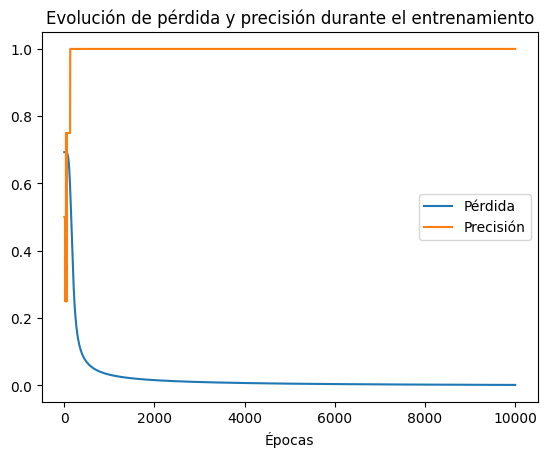

In [18]:
# Supongamos un conjunto simple XOR para clasificación binaria
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])

# Instancia del perceptrón multicapa
mlp = PerceptronMulticapa(capas=[2, 4, 1], eta=0.01)

# Variables para almacenar pérdida por época
epocas = 10000
perdidas = []

precisiones = []

for epoca in range(epocas):
    activaciones, zetas = mlp.forward(X)
    perdida = mlp.funcion_perdida(activaciones[-1], Y)
    precis = mlp.precision(activaciones[-1], Y)

    perdidas.append(perdida)
    precisiones.append(precis)

    grad_pesos, grad_bias = mlp.backward(activaciones, zetas, Y)
    mlp.actualizar_parametros(grad_pesos, grad_bias)

# Visualizamos pérdida y precisión
plt.plot(perdidas, label="Pérdida")
plt.plot(precisiones, label="Precisión")
plt.xlabel('Épocas')
plt.legend()
plt.title('Evolución de pérdida y precisión durante el entrenamiento')
plt.show()



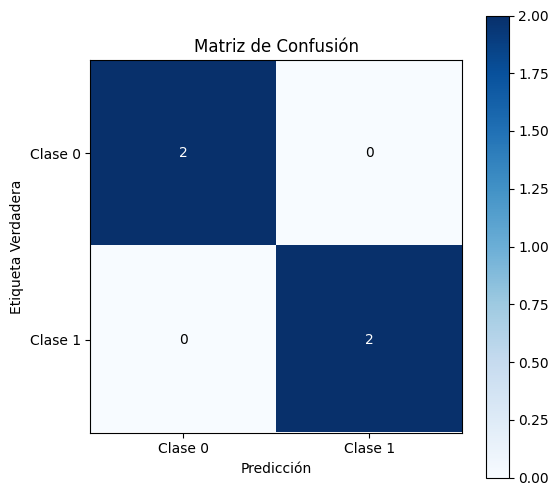

In [24]:
def matriz_confusion_np(y_true, y_pred, clases, cmap=plt.cm.Blues):
    """
    Calcula y visualiza la matriz de confusión sin dependencias externas.

    Parámetros:
    - y_true: etiquetas verdaderas (array numpy).
    - y_pred: etiquetas predichas (array numpy).
    - clases: lista o array con nombres de las clases.
    - cmap: mapa de color para la gráfica (opcional).
    """
    n_clases = len(clases)
    cm = np.zeros((n_clases, n_clases), dtype=int)

    for t, p in zip(y_true.flatten(), y_pred.flatten()):
        cm[int(t), int(p)] += 1

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Matriz de Confusión')
    plt.colorbar()
    tick_marks = np.arange(n_clases)
    plt.xticks(tick_marks, clases)
    plt.yticks(tick_marks, clases)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')

    thresh = cm.max() / 2.
    for i in range(n_clases):
        for j in range(n_clases):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.show()

matriz_confusion_np(y_true=Y, y_pred=Y_pred_labels, clases=['Clase 0', 'Clase 1'])
